In [27]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

from utils import smooth_inputs_dataset
from cm26_utils import load_and_combine_cm26

from xhistogram.xarray import histogram


# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)
%config InlineBackend.figure_format='retina'

In [28]:
ds = load_and_combine_cm26(fs, inline_array=True)

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [3]:
# import dask
# from distributed import LocalCluster, Client

# with dask.config.set({"distributed.scheduler.worker-saturation": "1.0"}):
#     client = Client(LocalCluster())
# client

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()

options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(2, 100)
client

[ClusterReport<name=prod.02839417452544b98bda5fcbc9d53c77, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.8b7ba391738c4dd6a67150dba9dd59c0/status,


In [51]:
ds_mean = ds[['surface_temp', 't_ref', 'q_ref']].mean('time').persist()

In [52]:
mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_mean.zarr')
ds_mean.to_zarr(mapper, consolidated=True, mode='w')

In [53]:
mask_mapper = fs.get_mapper('ocean-transport-group/scale-aware-air-sea/results/cm26_combined_map.zarr')
mask_combined = xr.open_dataset(mask_mapper, engine='zarr')['ice_land_mask']

In [54]:
ds_mean_reloaded = xr.open_dataset(mapper, engine='zarr', chunks={})

from utils import smooth_inputs_dataset
ds_mean_smooth = smooth_inputs_dataset(
    ds_mean_reloaded,
    ['yt_ocean', 'xt_ocean'],
    50
)

In [55]:
ds_mean_reloaded

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [58]:
ds_mean_smooth

<xarray.Dataset>
Dimensions:       (xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    surface_temp  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [56]:
from xgcm import Grid

In [57]:
mapper = fs.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
ds_oc_grid = xr.open_dataset(mapper, engine='zarr', chunks={})
ds_oc_grid['xu_ocean'].attrs['axis'] = 'X'
ds_oc_grid['xt_ocean'].attrs['axis'] = 'X'
ds_oc_grid['xu_ocean'].attrs['c_grid_axis_shift'] = 0.5
ds_oc_grid['xt_ocean'].attrs['c_grid_axis_shift'] = 0.0
ds_oc_grid['yu_ocean'].attrs['axis'] = 'Y'
ds_oc_grid['yt_ocean'].attrs['axis'] = 'Y'
ds_oc_grid['yu_ocean'].attrs['c_grid_axis_shift'] = 0.5
ds_oc_grid['yt_ocean'].attrs['c_grid_axis_shift'] = 0.0

grid = Grid(ds_oc_grid, metrics={('X',):['dxu', 'dxt'], ('Y',):['dyu', 'dyt']})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [59]:
def laplacian(da):
    da_dx = grid.derivative(da, 'X')
    da_dy = grid.derivative(da, 'Y')
    da_dx_dx = grid.derivative(da_dx, 'X')
    da_dy_dy = grid.derivative(da_dy, 'Y')
    return da_dx_dx + da_dy_dy

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('yt_ocean', 'xu_ocean') being interpolated from metrics at dimensions ('yt_ocean', 'xt_ocean'). Boundary value set to 'extend'.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('yu_ocean', 'xt_ocean') being interpolated from metrics at dimensions ('yt_ocean', 'xt_ocean'). Boundary value set to 'extend'.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('yt_ocean', 'xu_ocean') being interpolated from metrics at dimensions ('yt_ocean', 'xt_ocean'). Boundary value set to 'extend'.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/grid.py:1643: UserWarning: Metric at ('yu_ocean', 'xt_ocean') being interpolated from metrics at dimensions ('yt_ocean', 'xt_ocean'). Boundary value set to 'extend'.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3

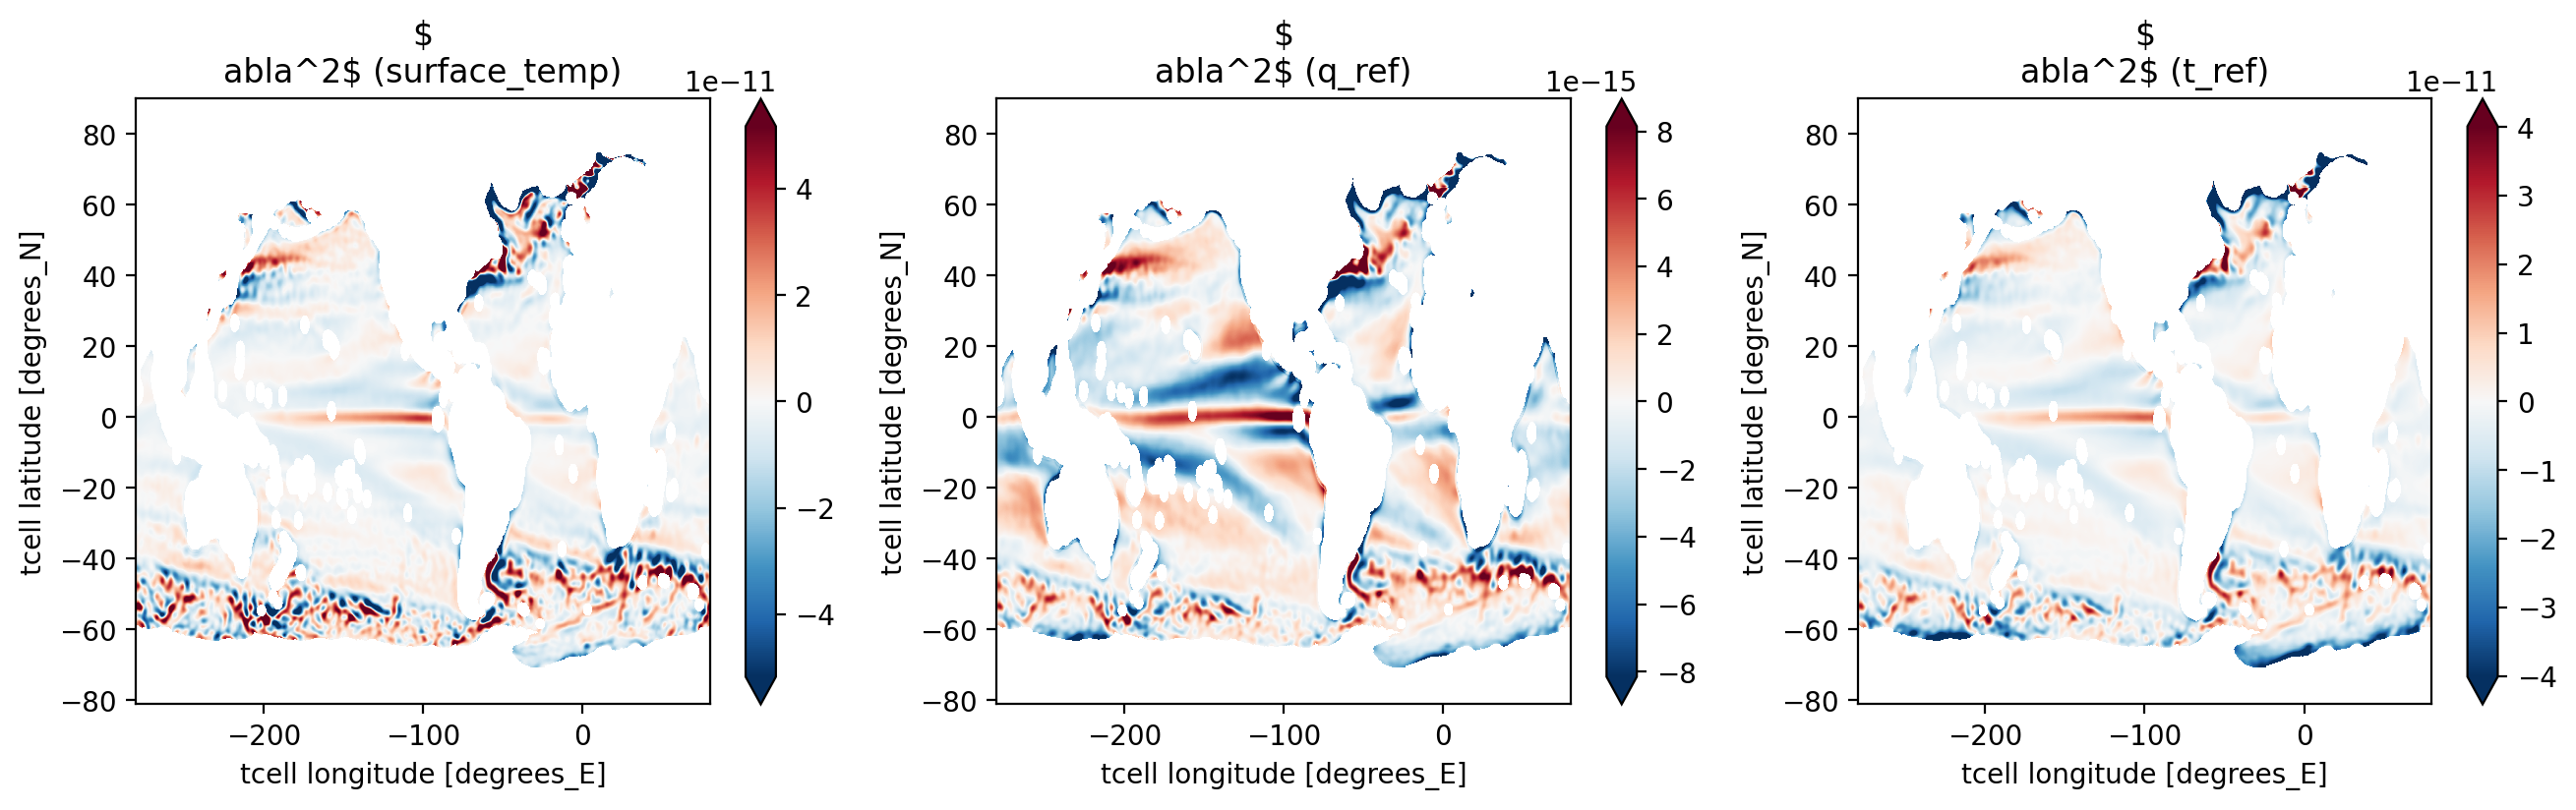

In [60]:
plt.figure(figsize=[16,4])
i = 1
for var in ['surface_temp', 'q_ref', 't_ref']:
    plt.subplot(1,3,i)
    laplacian(ds_mean_smooth[var]).where(mask_combined).plot(robust=True)
    plt.title(f"$\nabla^2$ ({var})")
    i += 1
plt.show()